In [9]:
# ================================
# Dataset Integrity & Preparation
# ================================

In [2]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Mount Google Drive once

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Define project paths

PROJECT_ROOT = "/content/drive/MyDrive/Capstone_X-ray_Project"
DATA_DIR = f"{PROJECT_ROOT}/Data/chest_xray_lung"

In [16]:
# --------------------------------
# Fast corrupted image detection
# --------------------------------
# Using load() for speed

def check_images_fast(base_dir):
    bad_images = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        img.load()  # Faster than verify
                except Exception as e:
                    bad_images.append((path, str(e)))
    return bad_images

**Required Install**: imagehash  
**code**: !pip install imagehash

In [7]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 9.4 MB/s eta 0:00:00


In [17]:
# --------------------------------
# Duplicate detection using pHash
# --------------------------------
# Perceptual hashing detects visually identical images
# Hash collisions are acceptable for medical imaging QC

import os
from PIL import Image
import imagehash

def find_duplicates_phash(base_dir):
    hash_map = {}
    duplicates = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)

                try:
                    with Image.open(file_path) as img:
                        phash = imagehash.phash(img)
                except Exception as e:
                    print(f"Skipping unreadable image: {file_path}")
                    continue

                if phash in hash_map:
                    duplicates.append({
                        "original": hash_map[phash],
                        "duplicate": file_path
                    })
                else:
                    hash_map[phash] = file_path

    return duplicates

In [18]:
#ROOT_DIR = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung"

# Output the number of duplicates
# Note: Takes about 3 mins to complete
duplicates_found = find_duplicates_phash(DATA_DIR)
print(f"Found {len(duplicates_found)} duplicate images")

Found 0 duplicate images


Found 32 duplicate images initially

In [7]:
for i, pair in enumerate(duplicates_found[:10]):  # show first 10
    print(f"\nDuplicate pair {i+1}:")
    print("Original :", pair["original"])
    print("Duplicate:", pair["duplicate"])


Duplicate pair 1:
Original : /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer460.jpeg
Duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer461.jpeg

Duplicate pair 2:
Original : /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer388.jpeg
Duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer389.jpeg

Duplicate pair 3:
Original : /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer486.jpeg
Duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer487.jpeg

Duplicate pair 4:
Original : /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer432.jpeg
Duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer431.jpeg

Duplicate pair 5:
Original : /content/drive/MyDrive/Capstone_X-ray_Project/

In [9]:
# --------------------------------
# Controlled duplicate deletion
# --------------------------------
# dry_run ensures safety before permanent deletion

def delete_duplicates(duplicates, dry_run=True):
    for pair in duplicates:
        dup_path = pair["duplicate"]
        try:
            if dry_run:
                print(f"[DRY RUN] Would delete: {dup_path}")
            else:
                os.remove(dup_path)
                print(f"Deleted duplicate: {dup_path}")
        except Exception as e:
            print(f"Error deleting {dup_path}: {e}")


In [10]:
# Permanent deletion

delete_duplicates(duplicates_found, dry_run=False)

Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer461.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer389.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer487.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer431.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer462.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer495.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer856.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train/Cancer/cancer2922.jpeg
Deleted duplicate: /content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/t

In [19]:
# Label verification

def verify_labels(base_dir, expected_labels=['NORMAL', 'Cancer']):
    mismatched = []
    for split in ['train', 'test', 'val']: # Splits identified in your notebook
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path): continue

        for label in os.listdir(split_path):
            if label not in expected_labels:
                mismatched.append(f"Unexpected folder found: {split}/{label}")

            # Additional check: verify files inside have correct extension
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                files = os.listdir(label_path)
                non_images = [f for f in files if not f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                if non_images:
                    mismatched.append(f"Non-image files in {split}/{label}: {non_images}")
    return mismatched

mismatches = verify_labels(DATA_DIR)
for m in mismatches:
    print(m)

In [21]:
# No of folders in dataset

number_of_img = {}
for dir in os.listdir(DATA_DIR):
    number_of_img[dir] = len(os.listdir(os.path.join(DATA_DIR,dir)))
number_of_img.items()


dict_items([('val', 2), ('train', 2), ('test', 2)])

In [27]:
# --------------------------------
# Dataset statistics
# --------------------------------
# Single source of truth for image counting

def count_images(base_dir):
    counts = {}
    for split in ["train", "val", "test"]:
        split_path = os.path.join(base_dir, split)
        counts[split] = {
            cls: len(os.listdir(os.path.join(split_path, cls)))
            for cls in os.listdir(split_path)
        }
    return counts

In [30]:
print(count_images(DATA_DIR))

{'train': {'Cancer': 3850, 'NORMAL': 1340}, 'val': {'Cancer': 8, 'NORMAL': 8}, 'test': {'NORMAL': 231, 'Cancer': 387}}


In [31]:
import random
import matplotlib.pyplot as plt

TRAIN_DIR = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/train"
NORMAL_DIR = os.path.join(TRAIN_DIR, "NORMAL")
CANCER_DIR = os.path.join(TRAIN_DIR, "Cancer")

In [32]:
normal_images = [
    os.path.join(NORMAL_DIR, img)
    for img in os.listdir(NORMAL_DIR)
    if img.lower().endswith(('.jpg', '.jpeg', '.png'))
]

cancer_images = [
    os.path.join(CANCER_DIR, img)
    for img in os.listdir(CANCER_DIR)
    if img.lower().endswith(('.jpg', '.jpeg', '.png'))
]

sample_images = (
    random.sample(normal_images, 3) +
    random.sample(cancer_images, 3)
)

random.shuffle(sample_images)

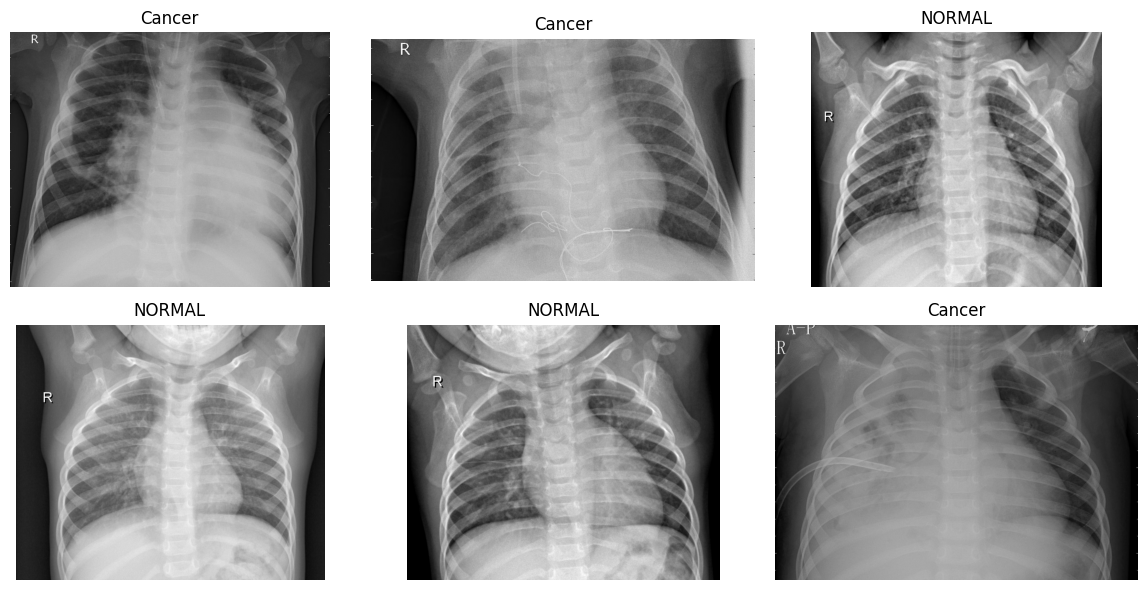

In [33]:
plt.figure(figsize=(12, 6))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(os.path.basename(os.path.dirname(img_path)))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [34]:
# Merging of the image in the train and val foders
import os
import shutil

BASE_DIR = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung"
MERGED_DIR = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/merged"

splits_to_merge = ["train", "val"]
classes = ["Cancer", "NORMAL"]

for cls in classes:
    os.makedirs(os.path.join(MERGED_DIR, cls), exist_ok=True)

for split in splits_to_merge:
    for cls in classes:
        src_dir = os.path.join(BASE_DIR, split, cls)
        dst_dir = os.path.join(MERGED_DIR, cls)

        for file in os.listdir(src_dir):
            shutil.copy(
                os.path.join(src_dir, file),
                os.path.join(dst_dir, file)
            )

In [35]:
# Resplit images into train and val
from sklearn.model_selection import train_test_split

NEW_TRAIN_DIR = os.path.join(BASE_DIR, "train_new")
NEW_VAL_DIR   = os.path.join(BASE_DIR, "val_new")

for cls in classes:
    os.makedirs(os.path.join(NEW_TRAIN_DIR, cls), exist_ok=True)
    os.makedirs(os.path.join(NEW_VAL_DIR, cls), exist_ok=True)

VAL_RATIO = 0.15
RANDOM_STATE = 42  # critical for reproducibility

for cls in classes:
    cls_dir = os.path.join(MERGED_DIR, cls)
    images = os.listdir(cls_dir)

    train_imgs, val_imgs = train_test_split(
        images,
        test_size=VAL_RATIO,
        random_state=RANDOM_STATE,
        shuffle=True
    )

    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_dir, img),
            os.path.join(NEW_TRAIN_DIR, cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(cls_dir, img),
            os.path.join(NEW_VAL_DIR, cls, img)
        )

In [36]:
# Replace old train and val
shutil.move(f"{BASE_DIR}/train", f"{BASE_DIR}/train_backup")
shutil.move(f"{BASE_DIR}/val", f"{BASE_DIR}/val_backup")

shutil.move(NEW_TRAIN_DIR, f"{BASE_DIR}/train")
shutil.move(NEW_VAL_DIR, f"{BASE_DIR}/val")


'/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung/val'

In [37]:
# --------------------------------
# Dataset statistics
# --------------------------------
# Single source of truth for image counting

def count_images(base_dir):
    counts = {}
    for split in ["train", "val", "test"]:
        split_path = os.path.join(base_dir, split)
        counts[split] = {
            cls: len(os.listdir(os.path.join(split_path, cls)))
            for cls in os.listdir(split_path)
        }
    return counts

In [38]:
print(count_images(DATA_DIR))

{'train': {'Cancer': 3279, 'NORMAL': 1145}, 'val': {'Cancer': 579, 'NORMAL': 203}, 'test': {'NORMAL': 231, 'Cancer': 387}}


In [39]:
# Save cleaned dataset

SRC = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung"
DST = "/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned"

for folder in ["train", "val", "test"]:
    shutil.copytree(
        os.path.join(SRC, folder),
        os.path.join(DST, folder)
    )

**PREPROCESSING**

In [40]:
import cv2
import numpy as np

# Z-score normalization function
def zscore_normalize(image, eps=1e-7):
    image = image.astype(np.float32)
    mean = np.mean(image)
    std = np.std(image)
    return (image - mean) / (std + eps)

def custom_preprocess(img):
    img = img.astype(np.uint8)

    # Grayscale handling
    if img.ndim == 3 and img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.squeeze()

    # Noise reduction
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Convert grayscale → RGB
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    # Z-score normalization
    img = zscore_normalize(img)

    return img


In [41]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
)


In [45]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/val',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 4424 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [46]:
train_generator.class_indices

{'Cancer': 0, 'NORMAL': 1}

In [19]:
# COMPARING ORIGINAL WITH RESULT

In [47]:
# Load Data
images, labels = next(train_generator)
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Batch shape: (32, 224, 224, 3), Labels: [0. 0. 1. 0. 1.]


In [48]:
img_path = '/content/drive/MyDrive/Capstone_X-ray_Project/Data/chest_xray_lung_v1_cleaned/train/NORMAL/IM-0115-0001.jpeg'

# Load original image (BGR → RGB)
original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)


In [49]:
preprocessed = custom_preprocess(original.copy())
# Convert from [-1,1] → [0,255]
preprocessed_vis = (preprocessed + 1) / 2
preprocessed_vis = np.clip(preprocessed_vis * 255, 0, 255).astype(np.uint8)


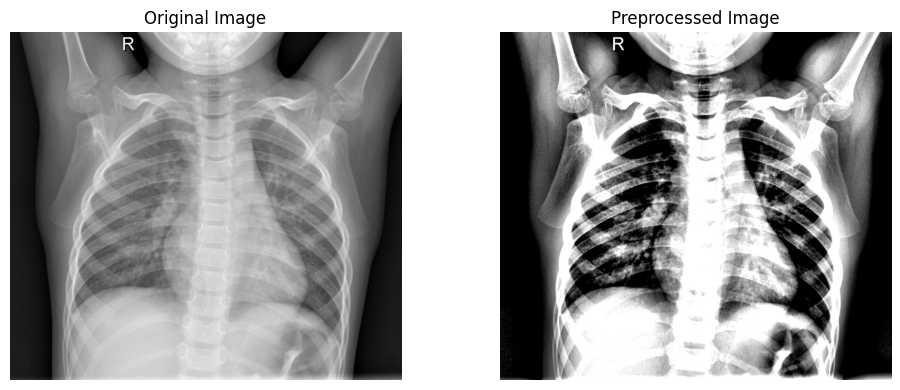

In [50]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_vis)
plt.title("Preprocessed Image")
plt.axis("off")

plt.tight_layout()
plt.show()
